In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from joblib import load
pd.set_option('display.max_rows', 25990)
pd.set_option('display.max_columns', 200)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


In [3]:
# Load merged cleaned dataset
merged_dir = Path("/content/drive/MyDrive/CP_UMBC/Feature_Engneering/Merged")
csv_files = sorted(merged_dir.glob("merged_clean_vA1_*.csv"))

if not csv_files:
    raise FileNotFoundError("No cleaned dataset found in Merged folder.")
else:
    latest_csv = csv_files[-1]
    print(f"Loaded dataset: {latest_csv.name}")

df = pd.read_csv(latest_csv)
print(f"Dataset shape: {df.shape}")
df.head()


Loaded dataset: merged_clean_vA1_20251201_0521.csv
Dataset shape: (25926, 31)


,MatricStatusOfficialDescr,MatricGenderIPEDS,MatricIPEDSEthnicity,MatricResidence,Graduated,Sem1_FTPT,MatricResidencyTuitionDescript,HighSchoolGpa,HighSchoolGPABandDescription,SATMathScore,SATReadingWritingScore,HighSchoolWeightedRankPercentile,HS_PecentileDesc,AlgSCORE,CalScore,ALEKSScore,EngSCORE,AP_CRDS,TotalSupport,Supported,NeedStatus,SupportBin,AP_total_transfer_credits,AP_max_score,AP_ct_art,AP_ct_computer,AP_ct_english,AP_ct_language,AP_ct_math,AP_ct_social,AP_ct_stem
0,New Transfer,Male,White,Commuter,0,FT,In State Resident,2.88,2.5 - 2.99,0.0,0.0,0,Unknown,0.0,0.0,0.0,0.0,0,0.0,No,Yes,NoSup,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,New Transfer,Male,White,Commuter,0,PT,In State Resident,0.00,Unknown,0.0,0.0,0,Unknown,0.0,0.0,0.0,0.0,0,1500.0,Yes,Yes,<5K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,New Transfer,Male,Asian,Commuter,1,FT,In State Resident,0.00,Unknown,0.0,0.0,0,Unknown,26.0,1.0,0.0,0.0,3,39711.0,Yes,Yes,>20K,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,New Transfer,Female,White,Commuter,1,FT,In State Resident,0.00,Unknown,0.0,0.0,0,Unknown,0.0,0.0,0.0,0.0,0,21015.0,Yes,Yes,>20K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,New Transfer,Male,Hispanic/Latino,Commuter,1,FT,In State Resident,0.00,Unknown,0.0,0.0,0,Unknown,25.0,19.0,0.0,3.0,0,0.0,No,Yes,NoSup,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Convert target to binary numeric
if df['Graduated'].dtype == 'O':
    df['Graduated'] = df['Graduated'].map({'Yes': 1, 'No': 0})

X = df.drop(columns=["Graduated"])
y = df["Graduated"].astype(int)

# Split data (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("\nData Split Summary:")
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)



Data Split Summary:
Train: (18148, 30)
Validation: (3889, 30)
Test: (3889, 30)


In [28]:
from joblib import load


xgb_tuned = load("/content/drive/MyDrive/CP_UMBC/Models/Tuned_Models/XGBoost_tuned_20251127_2057.joblib")

xgb_base = load("/content/drive/MyDrive/CP_UMBC/Models/Base_Models/XGBoost_base_20251130_2157.joblib")

gb_tuned = load("/content/drive/MyDrive/CP_UMBC/Models/Tuned_Models/GradientBoosting_tuned_20251127_2057.joblib")


print("All models loaded successfully!")


All models loaded successfully!


In [6]:
def compute_feature_importance(model, X_val):
    pre = model.named_steps["pre"]
    clf = model.named_steps["clf"]

    Xv = pre.transform(X_val)
    feature_names = pre.get_feature_names_out()
    importances = clf.feature_importances_

    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    top_features = imp_df.head(20).reset_index(drop=True)

    print("\nTOP 20 FEATURES")
    print(top_features)

    return top_features, feature_names, Xv


In [7]:
def compute_categorical_summary(model, X_val, y_val):
    df_val = X_val.copy()
    df_val["Graduated"] = y_val.values
    df_val["pred_grad_prob"] = model.predict_proba(df_val)[:, 1]

    cat_cols = df_val.select_dtypes(exclude=[np.number]).columns.tolist()

    def summarize(df, col):
        tab = (
            df.groupby(col, dropna=False)["pred_grad_prob"]
            .agg(mean_pred="mean", count="size")
            .sort_values("mean_pred", ascending=False)
        )
        tab["gap_from_top"] = tab["mean_pred"].max() - tab["mean_pred"]
        return tab

    all_summaries = []
    for col in cat_cols:
        tab = summarize(df_val, col).reset_index()
        tab["Feature"] = col
        all_summaries.append(tab)

    cat_summary = pd.concat(all_summaries, ignore_index=True)
    cat_summary = cat_summary.round({"mean_pred": 3, "gap_from_top": 3})

    print("\n CATEGORICAL SUMMARY ")
    display(cat_summary)

    return cat_summary


In [8]:
def compute_gap_analysis(cat_summary):
    gaps = (
        cat_summary.groupby("Feature")["mean_pred"]
        .agg(["max", "min", "count"])
        .assign(Gap=lambda d: d["max"] - d["min"])
        .sort_values("Gap", ascending=False)
        .round(3)
    )

    print("\n GAP ANALYSIS")
    display(gaps)

    return gaps


In [9]:
import matplotlib.pyplot as plt

def plot_categorical_graphs(cat_summary, gaps, model_name):

    print(f"\n=== GENERATING CATEGORY GRAPHS for: {model_name} ===\n")

    # Loop through each categorical variable, ordered by largest GAP
    for feature in gaps.index:
        sub = cat_summary[cat_summary["Feature"] == feature]

        plt.figure(figsize=(10, 0.6 * len(sub)))

        plt.barh(
            sub["Category"].astype(str),
            sub["mean_pred"],
            color="steelblue"
        )

        plt.xlabel("Mean Predicted Graduation Probability")
        plt.title(f"{model_name} — {feature}")
        plt.gca().invert_yaxis()

        # Add value labels
        for i, v in enumerate(sub["mean_pred"]):
            plt.text(v + 0.002, i, f"{v:.3f}", va="center", fontsize=9)

        plt.tight_layout()
        plt.show()


In [10]:
def compute_categorical_summary(model, X_val, y_val):
    df_val = X_val.copy()
    df_val["Graduated"] = y_val.values
    df_val["pred_grad_prob"] = model.predict_proba(df_val)[:, 1]

    cat_cols = df_val.select_dtypes(exclude=[np.number]).columns.tolist()

    def summarize(df, col):
        tab = (
            df.groupby(col, dropna=False)["pred_grad_prob"]
            .agg(mean_pred="mean", count="size")
            .sort_values("mean_pred", ascending=False)
        )
        tab["gap_from_top"] = tab["mean_pred"].max() - tab["mean_pred"]
        return tab

    all_summaries = []

    for col in cat_cols:
        tab = summarize(df_val, col).reset_index()

        #
        tab = tab.rename(columns={col: "Category"})

        tab["Feature"] = col
        all_summaries.append(tab)

    cat_summary = pd.concat(all_summaries, ignore_index=True)
    cat_summary = cat_summary.round({"mean_pred": 3, "gap_from_top": 3})

    print("\n CATEGORICAL SUMMARY")
    display(cat_summary)

    return cat_summary


In [11]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import pandas as pd

def plot_pdp(model, top_features, Xv, feature_names, model_name):
    clf = model.named_steps["clf"]
    X_val_top = pd.DataFrame(Xv, columns=feature_names)

    # Pick top 10 features
    top_feats = top_features["feature"].head(10).tolist()

    print(f"\nGenerating clean PDP plots for: {model_name}\n")

    for feat in top_feats:
        plt.figure(figsize=(8, 6))

        PartialDependenceDisplay.from_estimator(
            clf,
            X_val_top,
            features=[feat],
            kind="average",
            grid_resolution=50
        )

        plt.title(f"PDP — {model_name} — {feat}", fontsize=16)
        plt.tight_layout()
        plt.show()


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_pdp_manual(model, top_features, Xv, feature_names, model_name):

    clf = model.named_steps["clf"]
    X_df = pd.DataFrame(Xv, columns=feature_names)

    feats = top_features["feature"].head(10).tolist()
    print(f"\nManual PDP for: {model_name}\n")

    for feat in feats:

        if feat not in X_df.columns:
            print(f"Skipping {feat} (not in transformed features)")
            continue

        # Create grid for this feature
        values = np.linspace(
            X_df[feat].min(),
            X_df[feat].max(),
            30                      # grid resolution
        )

        pdp_vals = []

        for val in values:
            X_temp = X_df.copy()
            X_temp[feat] = val

            # probability prediction
            pred = clf.predict_proba(X_temp)[:, 1].mean()
            pdp_vals.append(pred)

        # Plot
        plt.figure(figsize=(7, 5))
        plt.plot(values, pdp_vals, linewidth=2)
        plt.title(f"PDP — {model_name} — {feat}", fontsize=14)
        plt.xlabel(feat)
        plt.ylabel("Partial Dependence")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()


In [13]:
def run_policy_simulation_top20(model, X, X_val):


    import pandas as pd
    import numpy as np
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

    pre = model.named_steps["pre"]
    clf = model.named_steps["clf"]

    # FEATURE IMPORTANCE

    enc_names = pre.get_feature_names_out()

    imp_df = pd.DataFrame({
        "feature": enc_names,
        "importance": clf.feature_importances_
    }).sort_values("importance", ascending=False)

    # Remove academic year
    imp_df = imp_df[~imp_df["feature"].str.contains("MatricAcademicYear")]

    # Map encoded to raw names
    def get_raw_name(enc):
        if "_" in enc:
            base = enc.split("_")[0]
            if base in X.columns:
                return base
        if enc in X.columns:
            return enc
        return None

    imp_df["raw"] = imp_df["feature"].apply(get_raw_name)
    imp_df = imp_df.dropna(subset=["raw"])

    # Get unique top 20 raw feature names
    top20_raw = imp_df["raw"].drop_duplicates().head(20).tolist()

    #print("\n==============================")
    #print(" TOP 20 RAW FEATURES SELECTED")
    #print("==============================")
    #for f in top20_raw:
       # print(" •", f)

    #
    # 2. BASELINE
    #
    baseline_prob = model.predict_proba(X_val)[:, 1].mean()
    print(f"\nBaseline predicted probability: {baseline_prob:.3f}")

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    results = []

    # ============================
    # 3. SIMULATE POLICY CHANGES
    # ============================
    for feat in top20_raw:

        # --------------------------
        # NUMERIC FEATURE
        # --------------------------
        if feat in num_cols:

            for pct in [-20, -10, 10, 20]:

                X_mod = X_val.copy()
                X_mod[feat] = X_mod[feat] * (1 + pct/100)

                # Clip GPA
                if "gpa" in feat.lower():
                    X_mod[feat] = np.clip(X_mod[feat], 0, 4)

                prob = model.predict_proba(X_mod)[:, 1].mean()
                lift = (prob - baseline_prob) * 100

                results.append({
                    "Feature": feat,
                    "Type": "Numeric",
                    "Change": f"{pct:+d}%",
                    "NewProb": round(prob, 4),
                    "Lift(pts)": round(lift, 3)
                })

        # --------------------------
        # CATEGORICAL FEATURE
        # --------------------------
        elif feat in cat_cols:

            unique_vals = X_val[feat].dropna().unique().tolist()

            for cat in unique_vals:
                X_mod = X_val.copy()
                X_mod[feat] = cat

                prob = model.predict_proba(X_mod)[:, 1].mean()
                lift = (prob - baseline_prob) * 100

                results.append({
                    "Feature": feat,
                    "Type": "Categorical",
                    "Change": f"Force={cat}",
                    "NewProb": round(prob, 4),
                    "Lift(pts)": round(lift, 3)
                })

        else:
            print(f"Skipping: {feat} (not found in raw X)")

    # ============================
    # 4. FINAL RESULT TABLE
    # ============================
    policy_df = pd.DataFrame(results)
    policy_df = policy_df.sort_values("Lift(pts)", ascending=False).reset_index(drop=True)

    #print("\n==============================================")
    print(" POLICY SIMULATION RESULTS (TOP 20 FEATURES) ")
    #print("==============================================")
    print(policy_df.to_string(index=False))

    return policy_df


In [14]:
model = xgb_base
model_name = "XGBoost Base"

print(f"\n\n RUNNING ANALYSIS FOR: {model_name} \n")

#  Feature importance
top_features, feature_names, Xv = compute_feature_importance(model, X_val)



 RUNNING ANALYSIS FOR: XGBoost Base 


TOP 20 FEATURES
                                              feature  importance
0                                            EngSCORE    0.146715
1              MatricStatusOfficialDescr_New Transfer    0.063279
2                                          ALEKSScore    0.060936
3                                     SupportBin_>20K    0.040874
4                                      SupportBin_<5K    0.036339
5                                        TotalSupport    0.032069
6                              SATReadingWritingScore    0.021743
7   MatricResidencyTuitionDescript_Out of State Re...    0.020816
8                                  SupportBin_15K-20K    0.020422
9                                      AP_ct_computer    0.020099
10                                       SATMathScore    0.019098
11                                     NeedStatus_Yes    0.018868
12                                  SupportBin_5K-10K    0.018199
13                 

In [15]:
# Categorical summary
cat_summary = compute_categorical_summary(model, X_val, y_val)


 CATEGORICAL SUMMARY


,Category,mean_pred,count,gap_from_top,Feature
0,New Transfer,0.616,1538,0.000,MatricStatusOfficialDescr
1,New Freshman,0.477,2351,0.140,MatricStatusOfficialDescr
2,Female,0.540,1450,0.000,MatricGenderIPEDS
3,Male,0.527,2439,0.013,MatricGenderIPEDS
4,Not Specified,0.630,134,0.000,MatricIPEDSEthnicity
5,White,0.595,1348,0.035,MatricIPEDSEthnicity
6,International,0.557,180,0.074,MatricIPEDSEthnicity
7,Asian,0.535,968,0.095,MatricIPEDSEthnicity
8,American Indian/Alaska Native,0.516,4,0.115,MatricIPEDSEthnicity
9,Unknown,0.463,2,0.167,MatricIPEDSEthnicity


In [16]:
# Gap analysis
gaps = compute_gap_analysis(cat_summary)


 GAP ANALYSIS


,max,min,count,Gap
Feature,,,,
MatricIPEDSEthnicity,0.630,0.045,10,0.585
SupportBin,0.675,0.275,6,0.400
HighSchoolGPABandDescription,0.765,0.459,10,0.306
MatricStatusOfficialDescr,0.616,0.477,2,0.139
Supported,0.613,0.494,2,0.119
HS_PecentileDesc,0.604,0.502,8,0.102
NeedStatus,0.578,0.521,2,0.057
Sem1_FTPT,0.536,0.488,2,0.048
MatricResidencyTuitionDescript,0.536,0.494,2,0.042



=== GENERATING CATEGORY GRAPHS for: XGBoost Base ===



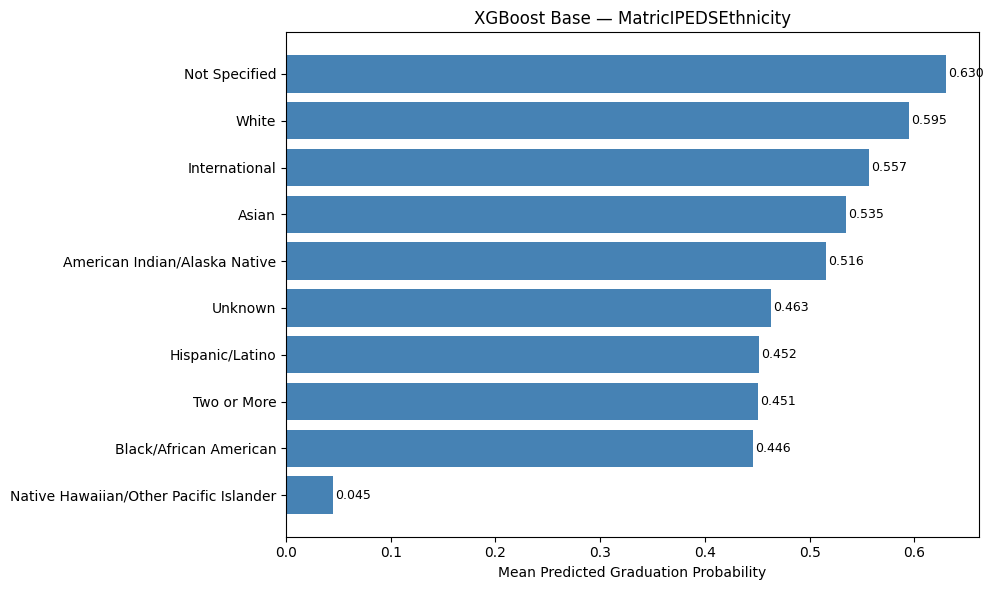

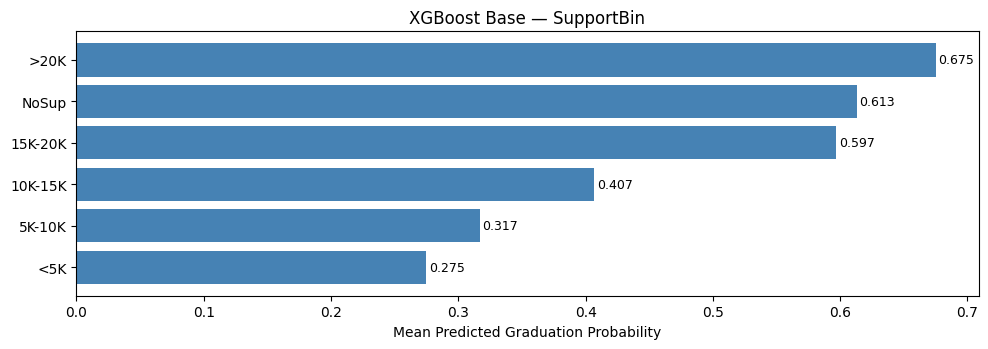

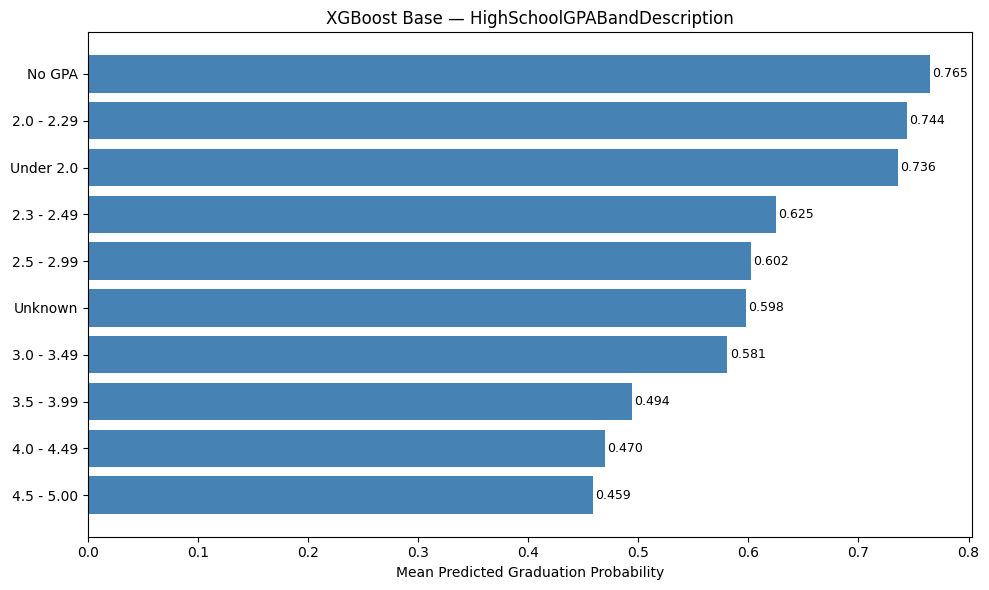

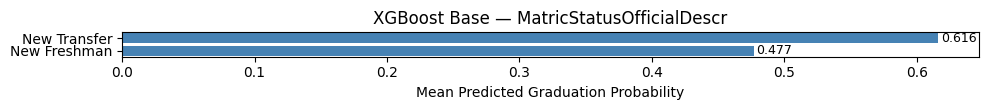

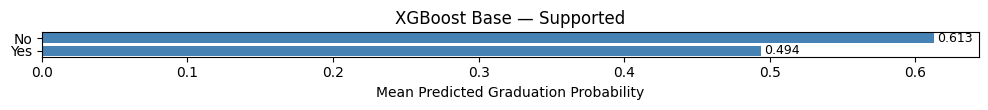

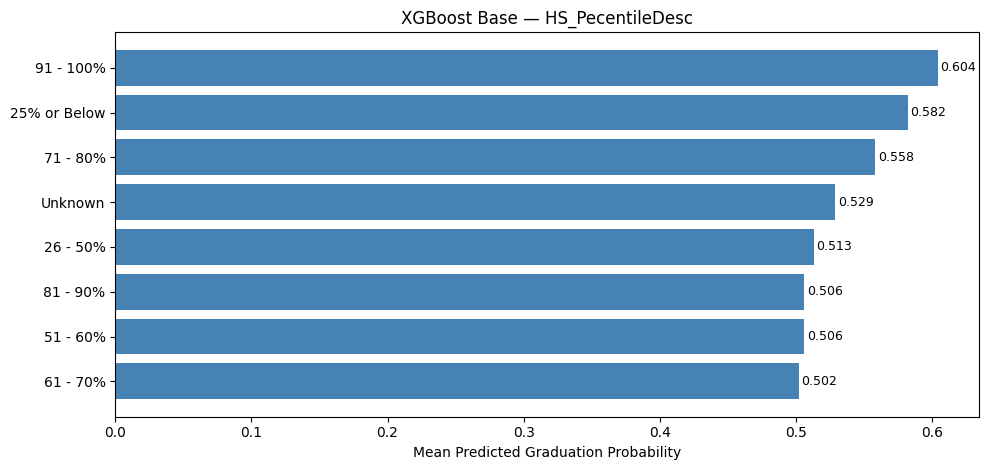

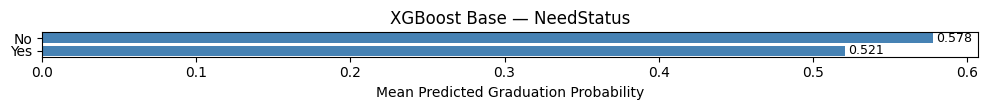

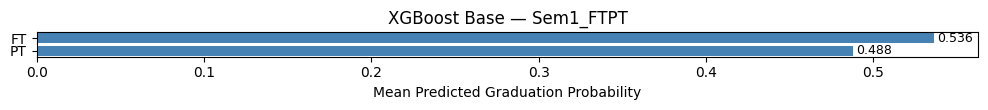

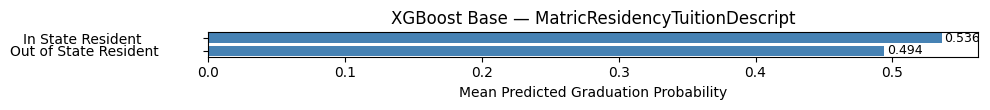

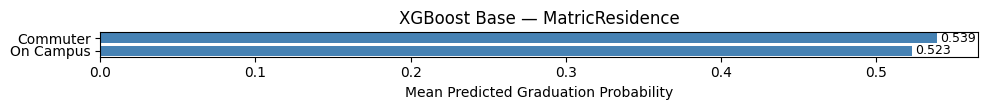

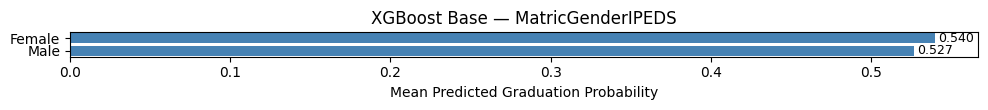

In [17]:
#  Category plots
plot_categorical_graphs(cat_summary, gaps, model_name)


Manual PDP for: XGBoost Base



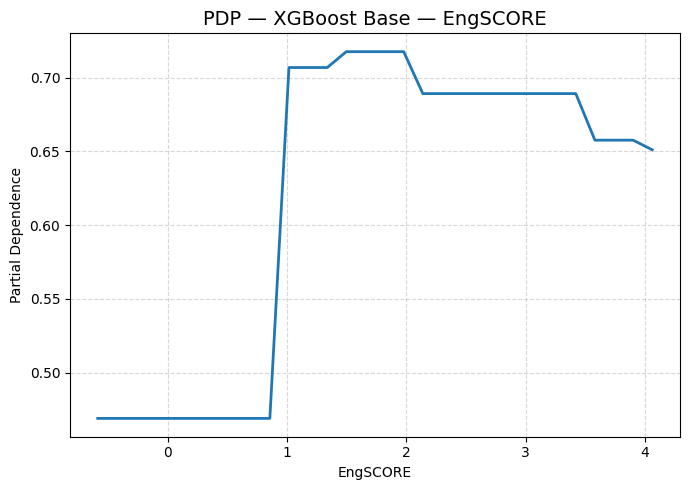

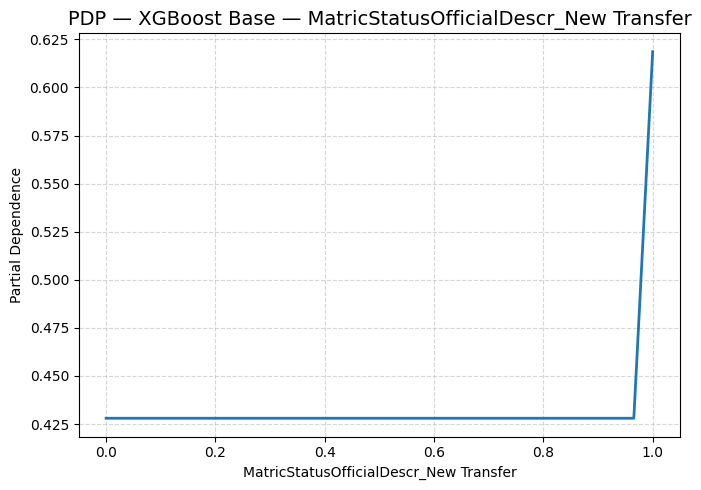

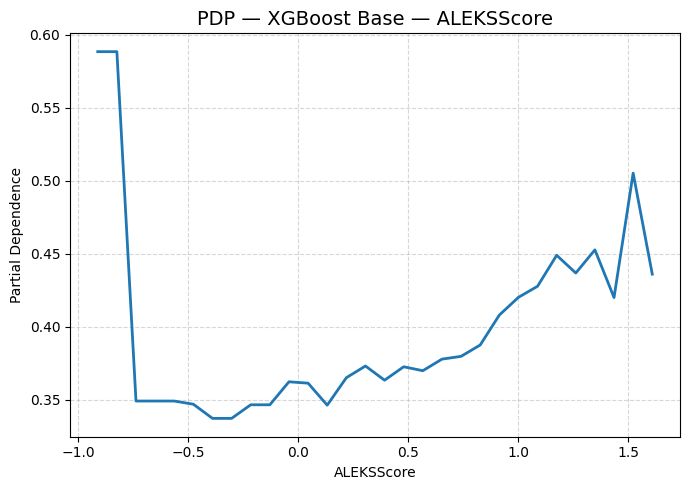

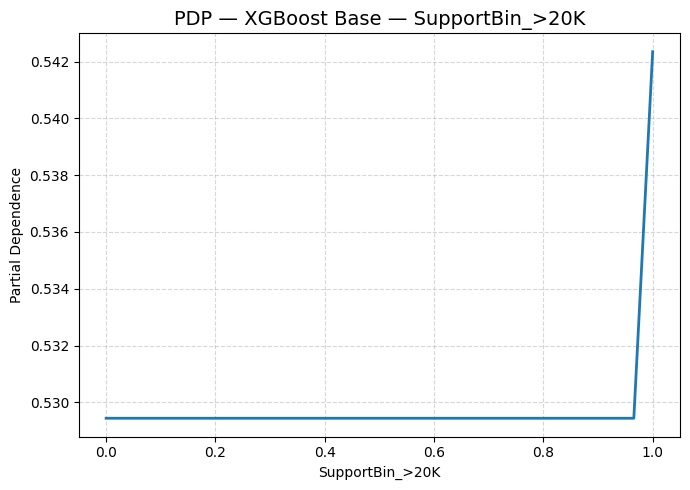

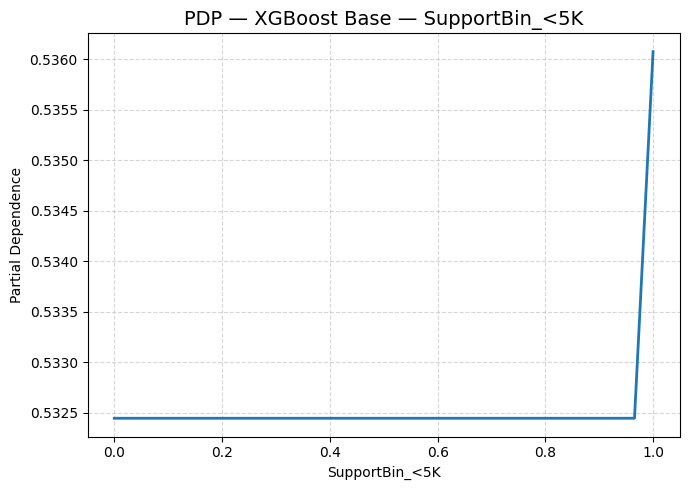

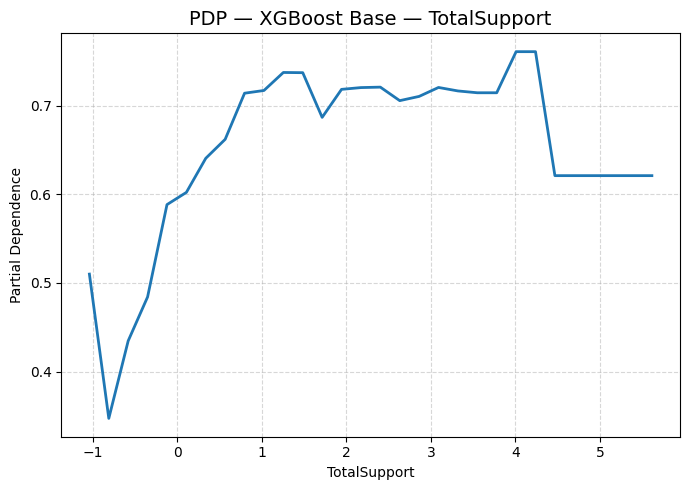

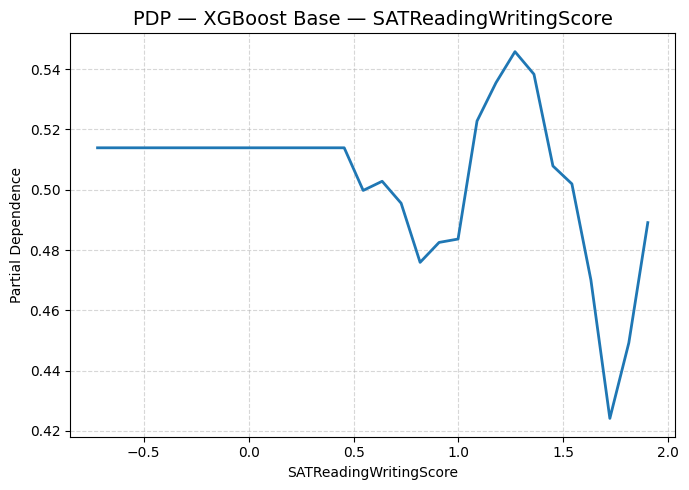

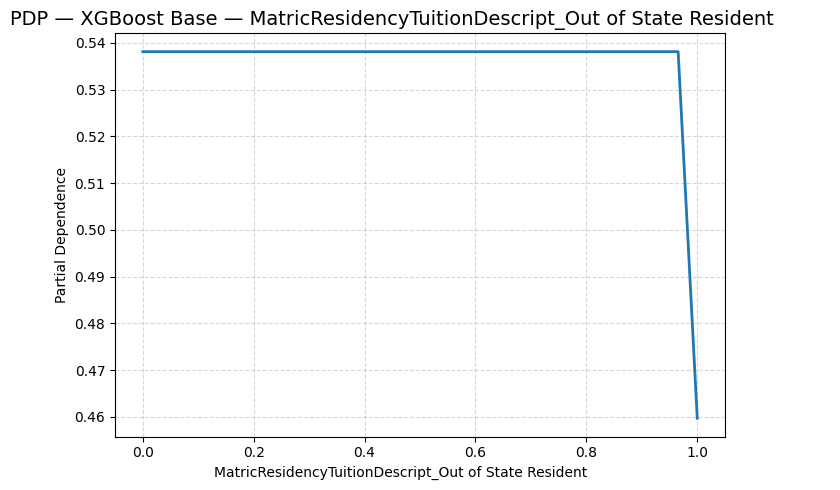

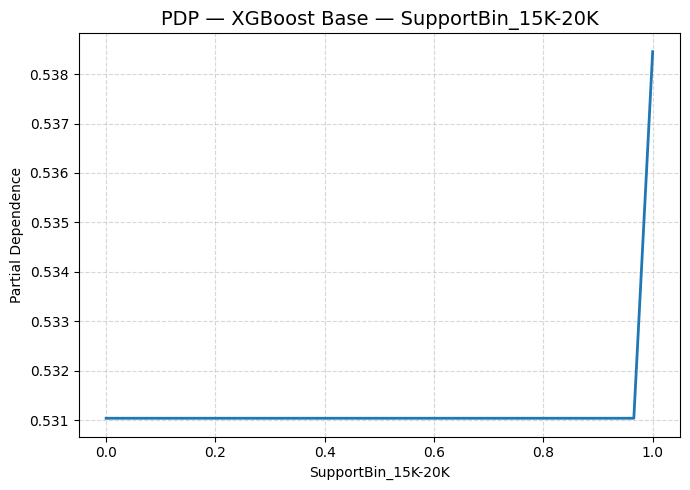

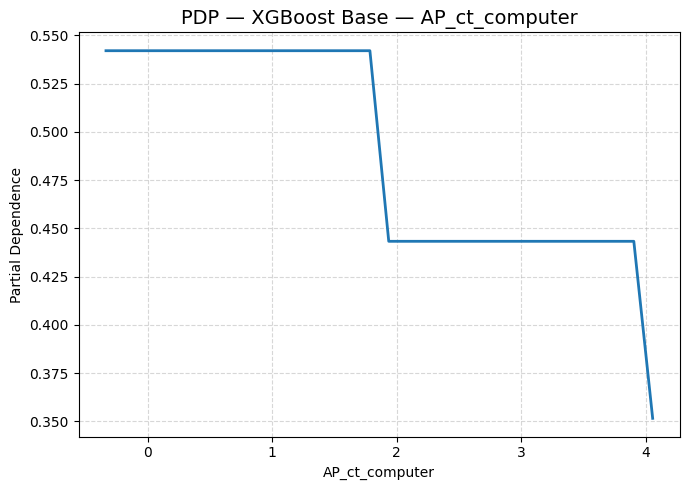

In [19]:
plot_pdp_manual(xgb_base, top_features, Xv, feature_names, "XGBoost Base")


In [20]:
print("\n\nPOLICY SIMULATION: XGBoost Base ")
policy_xgb_noyear = run_policy_simulation_top20(xgb_base, X, X_val)




POLICY SIMULATION: XGBoost Base 

Baseline predicted probability: 0.532
 POLICY SIMULATION RESULTS (TOP 20 FEATURES) 
                         Feature        Type                                       Change  NewProb  Lift(pts)
    HighSchoolGPABandDescription Categorical                                 Force=No GPA   0.6991     16.718
       MatricStatusOfficialDescr Categorical                           Force=New Transfer   0.6186      8.667
                      NeedStatus Categorical                                     Force=No   0.6070      7.506
            MatricIPEDSEthnicity Categorical                          Force=International   0.5881      5.615
    HighSchoolGPABandDescription Categorical                             Force=2.3 - 2.49   0.5857      5.372
            MatricIPEDSEthnicity Categorical                          Force=Not Specified   0.5518      1.987
            MatricIPEDSEthnicity Categorical                                  Force=Asian   0.5514      1.950


XGBOOST

In [22]:

model = xgb_tuned
model_name = "XGBoost Tuned"

print(f"\n\n RUNNING ANALYSIS FOR: {model_name} \n")

#  Feature importance
top_features, feature_names, Xv = compute_feature_importance(model, X_val)




 RUNNING ANALYSIS FOR: XGBoost Tuned 


TOP 20 FEATURES
                                        feature  importance
0                                      EngSCORE    0.149316
1                               SupportBin_>20K    0.098935
2        MatricStatusOfficialDescr_New Transfer    0.061828
3                                    ALEKSScore    0.046512
4                                SupportBin_<5K    0.034091
5                             SupportBin_5K-10K    0.026956
6                                  TotalSupport    0.026359
7                                  Sem1_FTPT_PT    0.020947
8                        SATReadingWritingScore    0.020868
9                                AP_ct_computer    0.020017
10                           SupportBin_15K-20K    0.019454
11                                 SATMathScore    0.018633
12                                 AP_max_score    0.018631
13                                Supported_Yes    0.016824
14                             SupportBin_

In [23]:
#  Categorical summary
cat_summary = compute_categorical_summary(model, X_val, y_val)




 CATEGORICAL SUMMARY


,Category,mean_pred,count,gap_from_top,Feature
0,New Transfer,0.543,1538,0.000,MatricStatusOfficialDescr
1,New Freshman,0.460,2351,0.084,MatricStatusOfficialDescr
2,Female,0.519,1450,0.000,MatricGenderIPEDS
3,Male,0.477,2439,0.042,MatricGenderIPEDS
4,American Indian/Alaska Native,0.641,4,0.000,MatricIPEDSEthnicity
5,Not Specified,0.589,134,0.052,MatricIPEDSEthnicity
6,Unknown,0.541,2,0.100,MatricIPEDSEthnicity
7,White,0.536,1348,0.105,MatricIPEDSEthnicity
8,Asian,0.505,968,0.136,MatricIPEDSEthnicity
9,International,0.455,180,0.186,MatricIPEDSEthnicity


In [24]:
#  Gap analysis
gaps = compute_gap_analysis(cat_summary)




 GAP ANALYSIS


,max,min,count,Gap
Feature,,,,
MatricIPEDSEthnicity,0.641,0.094,10,0.547
SupportBin,0.681,0.266,6,0.415
HS_PecentileDesc,0.629,0.399,8,0.230
HighSchoolGPABandDescription,0.559,0.463,10,0.096
MatricStatusOfficialDescr,0.543,0.460,2,0.083
Sem1_FTPT,0.498,0.428,2,0.070
NeedStatus,0.504,0.444,2,0.060
MatricGenderIPEDS,0.519,0.477,2,0.042
MatricResidencyTuitionDescript,0.496,0.462,2,0.034



=== GENERATING CATEGORY GRAPHS for: XGBoost Tuned ===



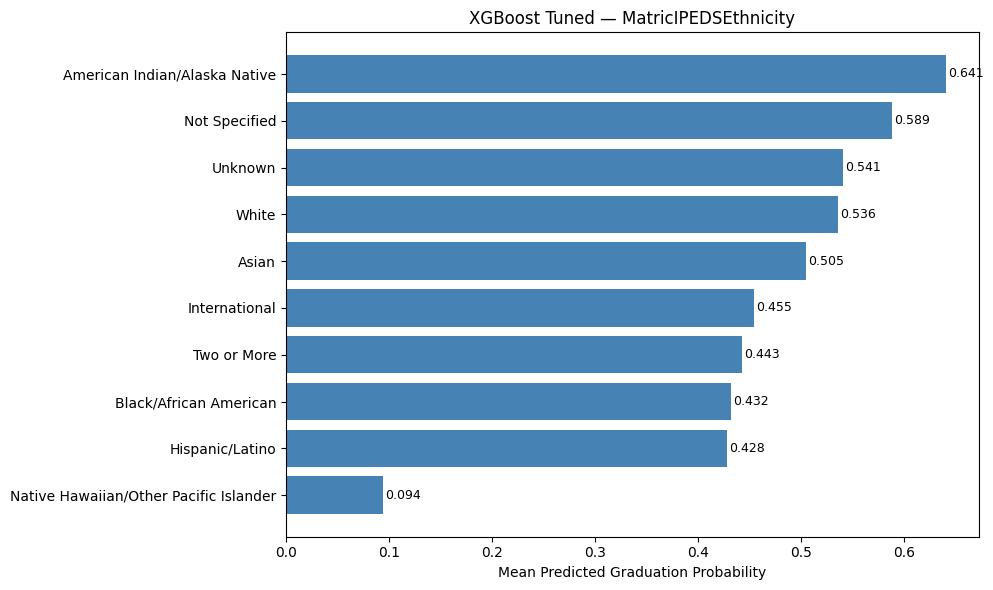

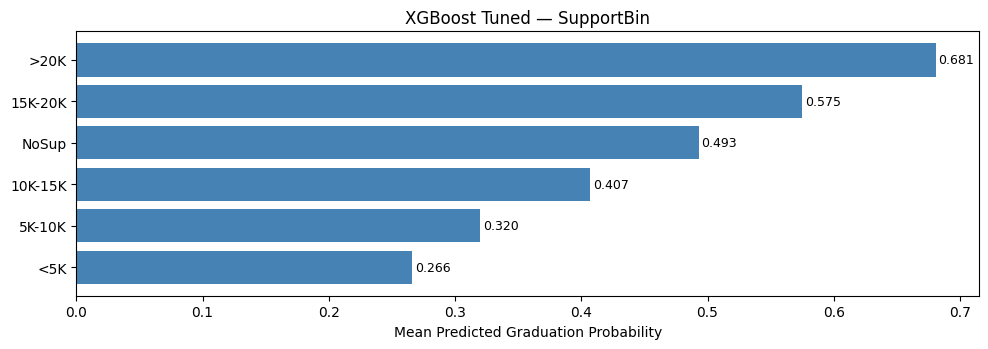

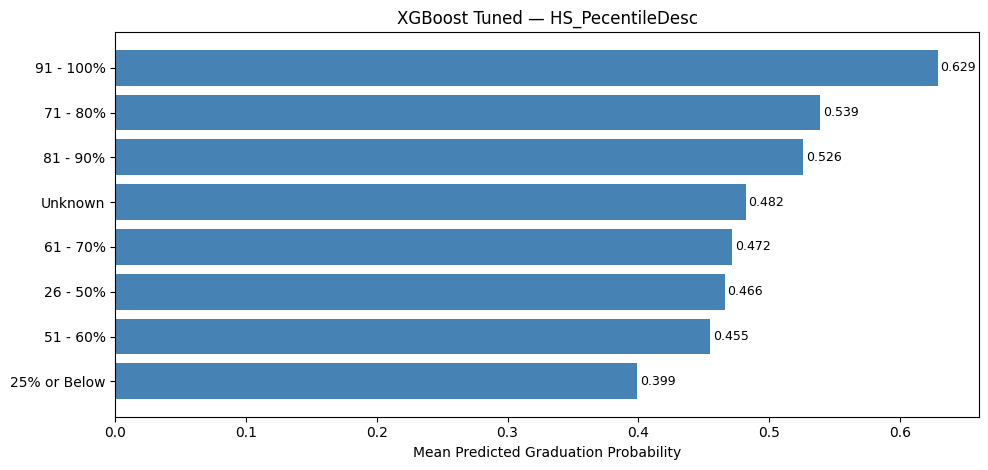

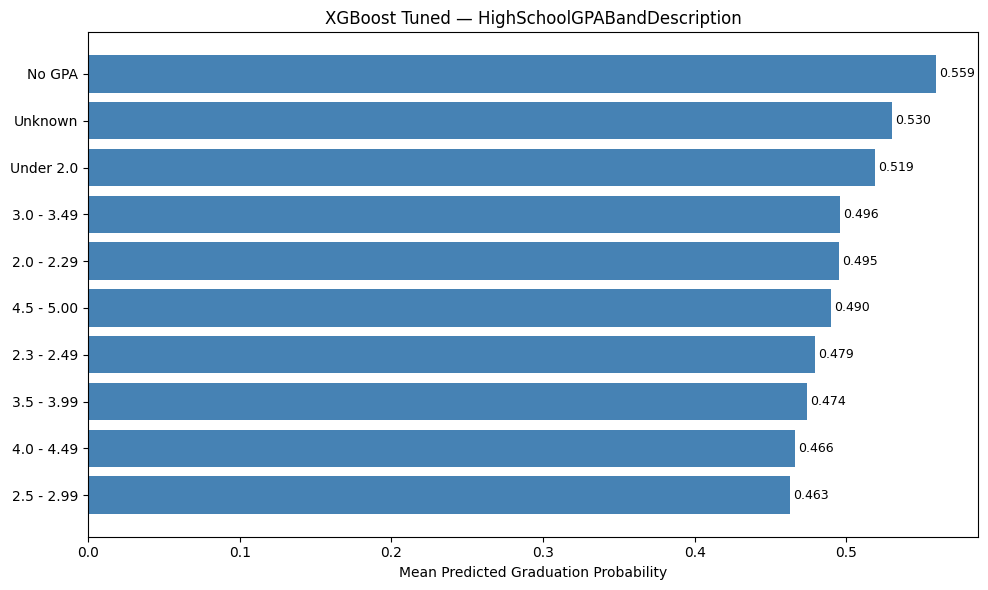

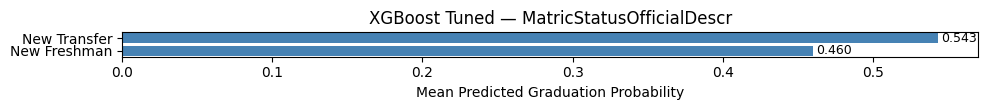

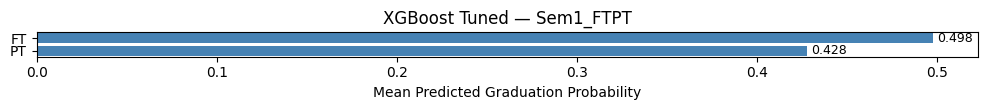

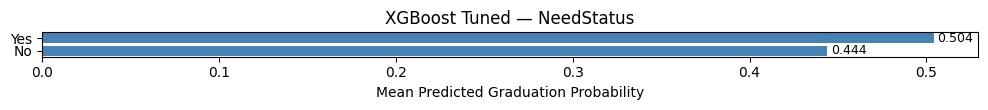

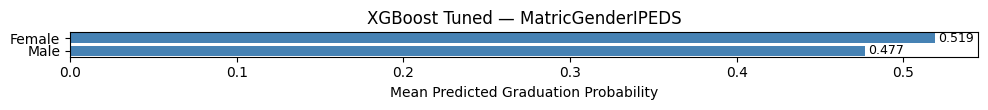

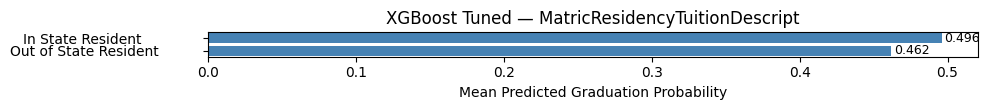

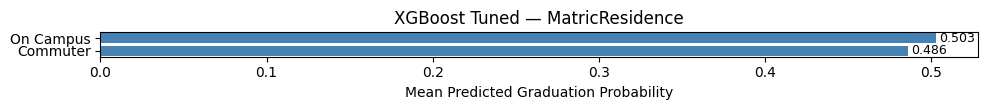

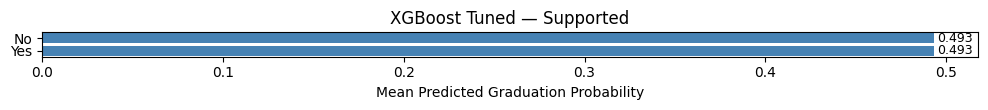

In [25]:
# Category plots
plot_categorical_graphs(cat_summary, gaps, model_name)




Manual PDP for: XGBoost tuned



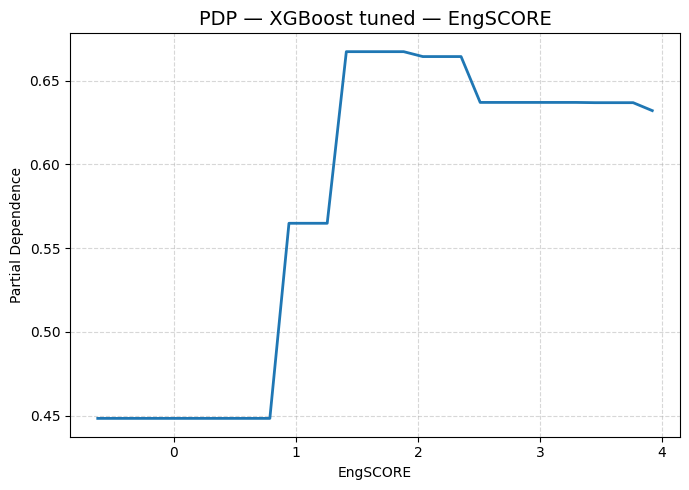

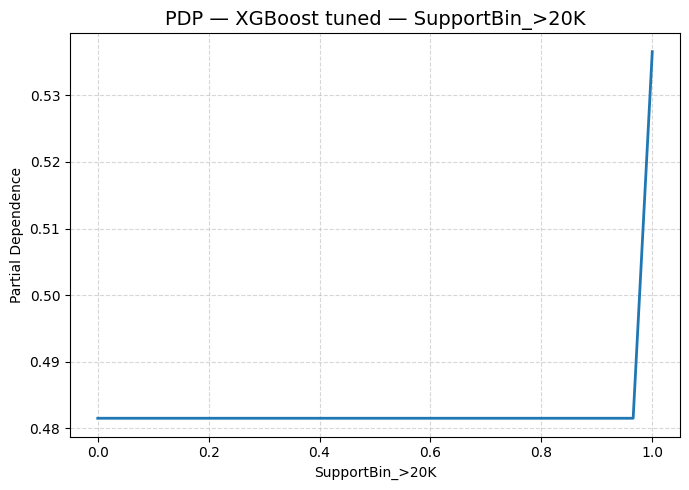

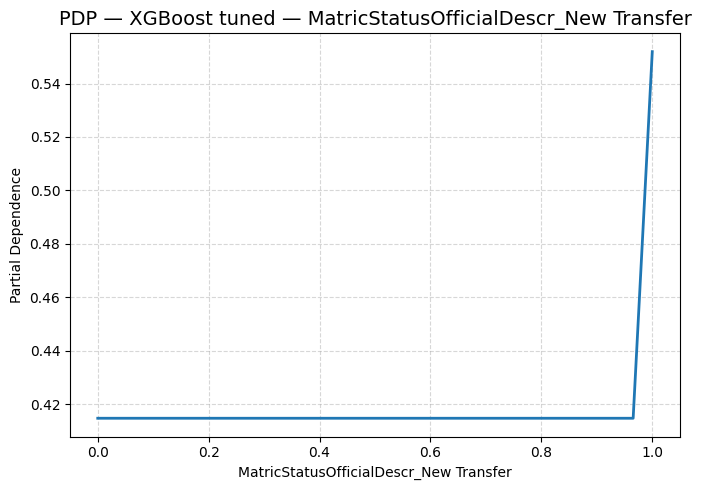

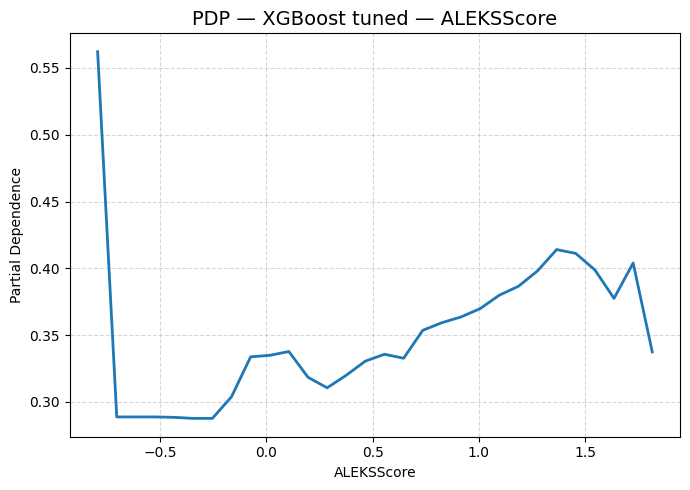

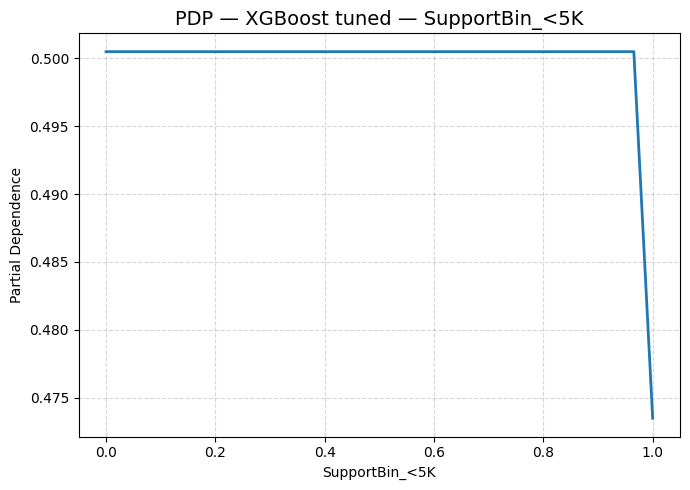

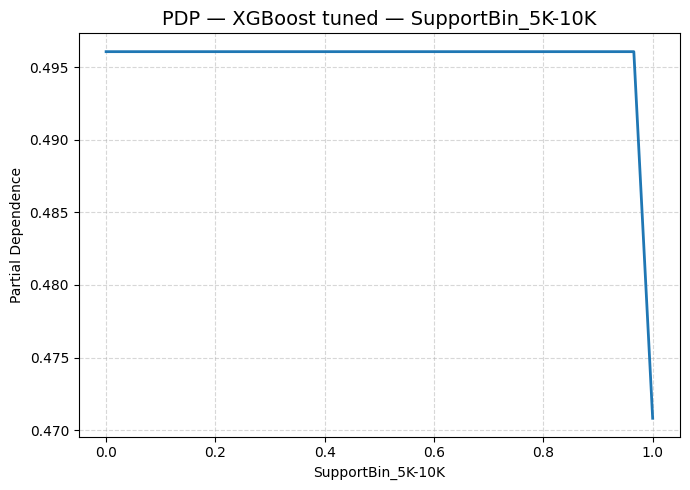

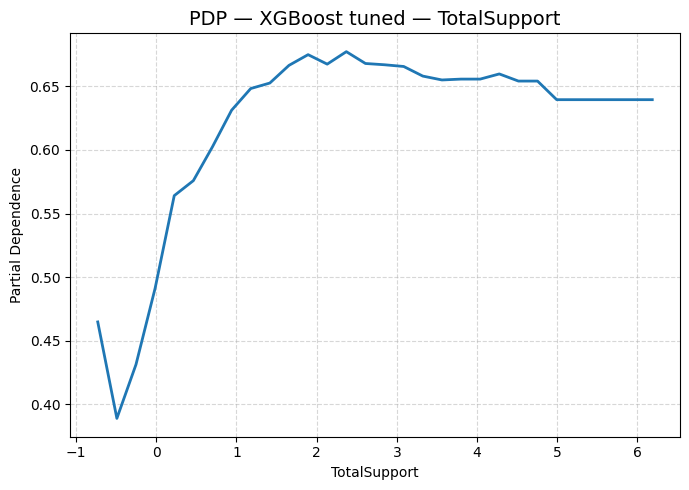

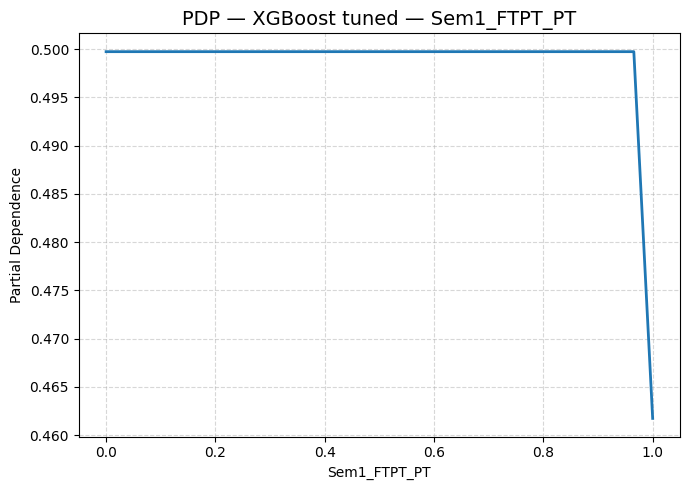

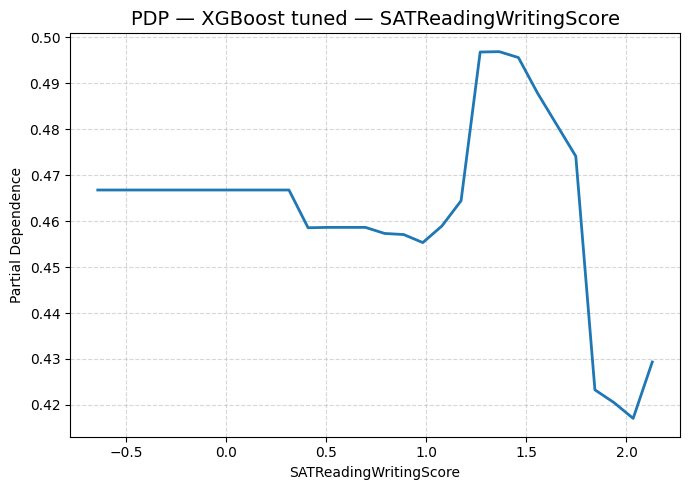

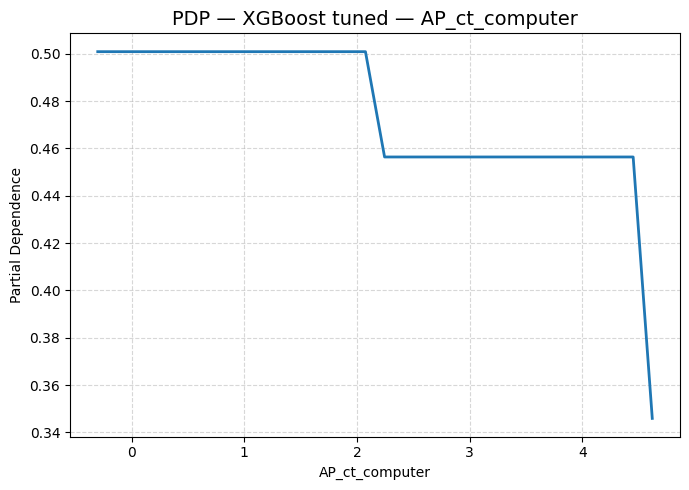

In [26]:
# PDP plots
plot_pdp_manual(xgb_tuned, top_features, Xv, feature_names, "XGBoost tuned")



In [27]:
print("\n\n POLICY SIMULATION: XGBoost Base")
policy_xgb_base = run_policy_simulation_top20(xgb_tuned, X, X_val)




 POLICY SIMULATION: XGBoost Base

Baseline predicted probability: 0.493
 POLICY SIMULATION RESULTS (TOP 20 FEATURES) 
                         Feature        Type                                       Change  NewProb  Lift(pts)
       MatricStatusOfficialDescr Categorical                           Force=New Transfer   0.5519      5.899
                      SupportBin Categorical                                   Force=>20K   0.5471      5.416
            MatricIPEDSEthnicity Categorical                          Force=International   0.5226      2.970
                      NeedStatus Categorical                                     Force=No   0.5215      2.859
            MatricIPEDSEthnicity Categorical                          Force=Not Specified   0.5203      2.739
                      SupportBin Categorical                                Force=15K-20K   0.5166      2.365
            MatricIPEDSEthnicity Categorical                                  Force=Asian   0.5144      2.144


Gradient Boosting


In [29]:

model = gb_tuned
model_name = "Gradient Boosting Tuned"

print(f"\n\n RUNNING ANALYSIS FOR: {model_name}\n")

# Feature importance
top_features, feature_names, Xv = compute_feature_importance(model, X_val)



 RUNNING ANALYSIS FOR: Gradient Boosting Tuned


TOP 20 FEATURES
                                              feature  importance
0                                        TotalSupport    0.235180
1                                          ALEKSScore    0.218012
2                                            EngSCORE    0.170752
3                              SATReadingWritingScore    0.050537
4              MatricStatusOfficialDescr_New Transfer    0.042862
5                                       HighSchoolGpa    0.039566
6                                        SATMathScore    0.032749
7                    HighSchoolWeightedRankPercentile    0.023419
8                                        AP_max_score    0.022391
9                                      AP_ct_computer    0.017158
10                                     SupportBin_<5K    0.013678
11                                       Sem1_FTPT_PT    0.013271
12                                           AlgSCORE    0.010751
13       

In [30]:
#  Categorical summary
cat_summary = compute_categorical_summary(model, X_val, y_val)



 CATEGORICAL SUMMARY


,Category,mean_pred,count,gap_from_top,Feature
0,New Transfer,0.548,1538,0.000,MatricStatusOfficialDescr
1,New Freshman,0.456,2351,0.091,MatricStatusOfficialDescr
2,Female,0.520,1450,0.000,MatricGenderIPEDS
3,Male,0.476,2439,0.043,MatricGenderIPEDS
4,American Indian/Alaska Native,0.612,4,0.000,MatricIPEDSEthnicity
5,Not Specified,0.606,134,0.007,MatricIPEDSEthnicity
6,White,0.537,1348,0.075,MatricIPEDSEthnicity
7,Asian,0.510,968,0.103,MatricIPEDSEthnicity
8,International,0.467,180,0.145,MatricIPEDSEthnicity
9,Unknown,0.435,2,0.177,MatricIPEDSEthnicity


In [31]:
#  Gap analysis
gaps = compute_gap_analysis(cat_summary)



 GAP ANALYSIS


,max,min,count,Gap
Feature,,,,
MatricIPEDSEthnicity,0.612,0.109,10,0.503
SupportBin,0.679,0.264,6,0.415
HighSchoolGPABandDescription,0.623,0.302,10,0.321
HS_PecentileDesc,0.621,0.375,8,0.246
MatricStatusOfficialDescr,0.548,0.456,2,0.092
Sem1_FTPT,0.498,0.423,2,0.075
NeedStatus,0.503,0.450,2,0.053
MatricGenderIPEDS,0.520,0.476,2,0.044
MatricResidencyTuitionDescript,0.496,0.457,2,0.039



=== GENERATING CATEGORY GRAPHS for: Gradient Boosting Tuned ===



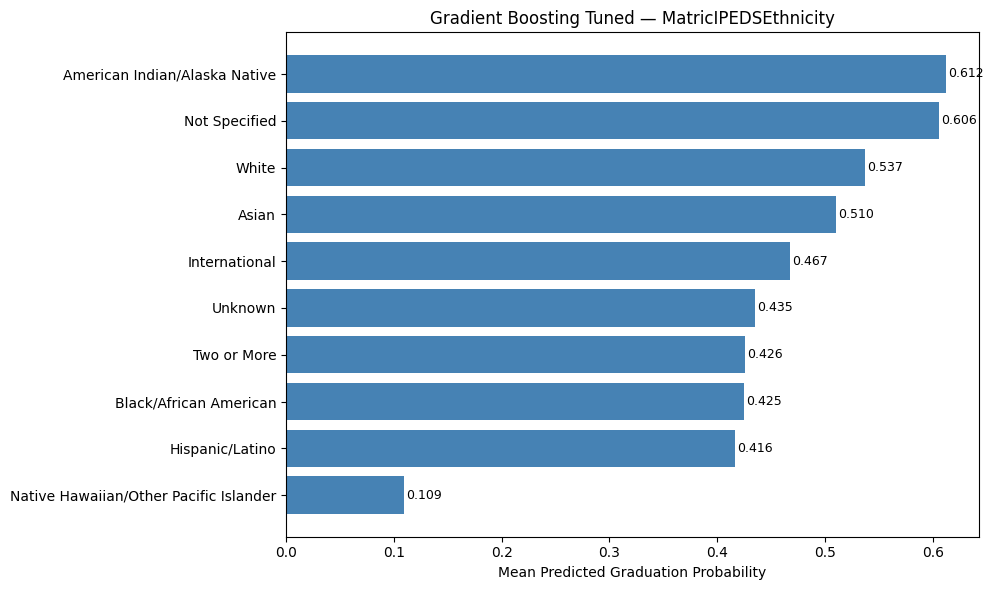

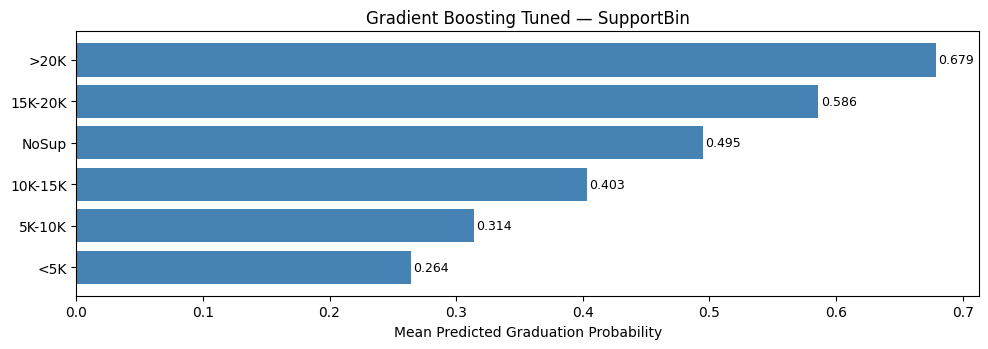

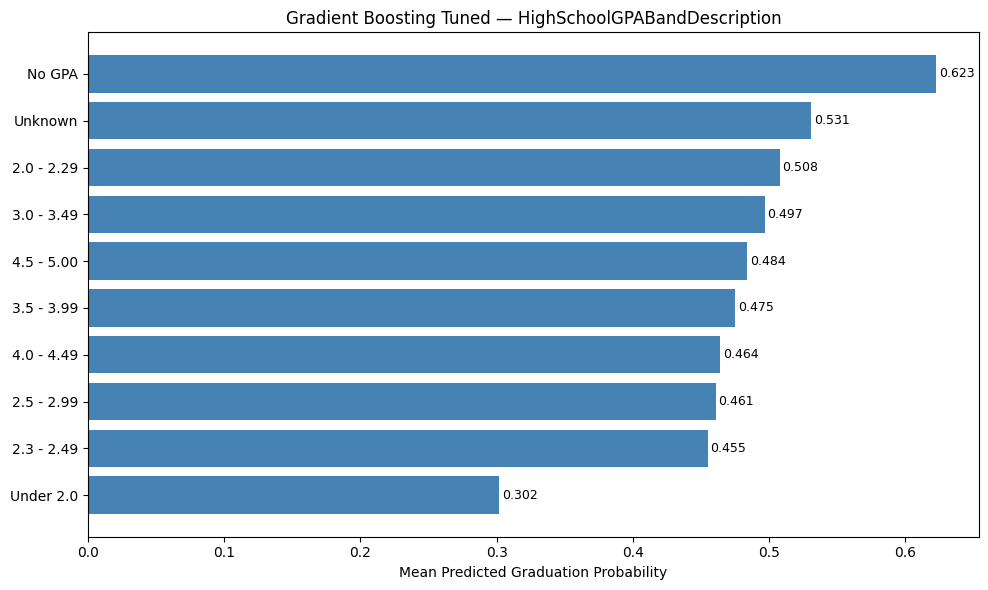

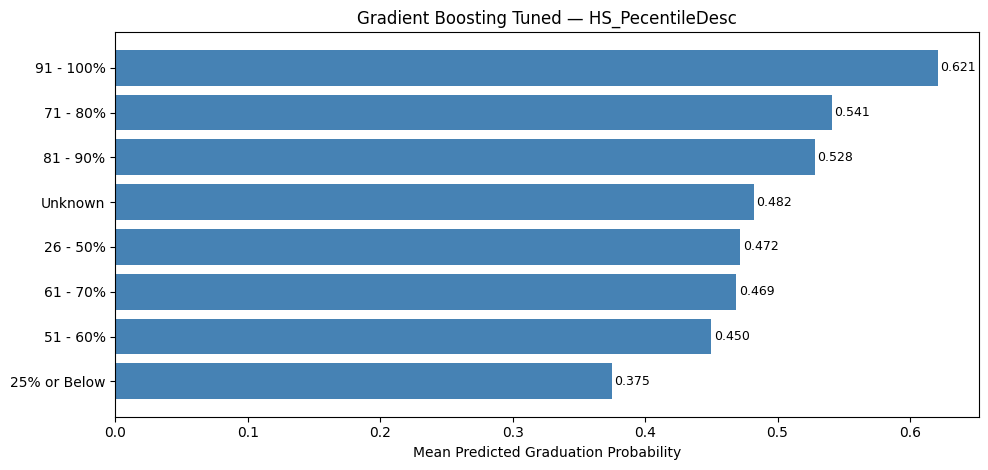

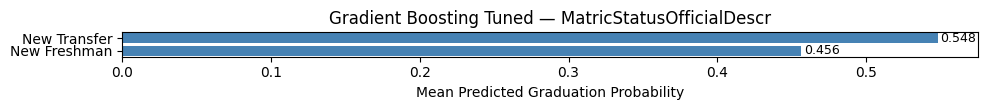

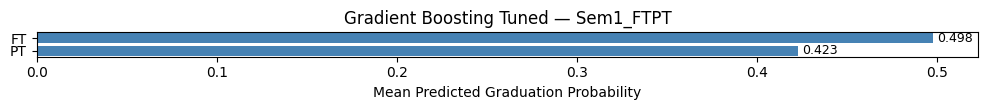

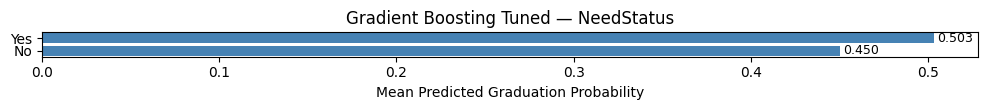

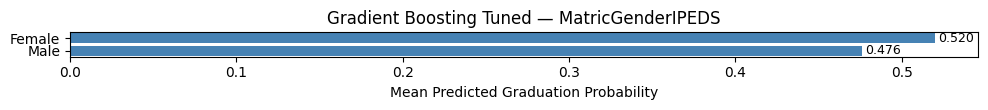

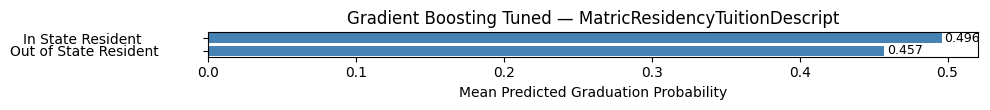

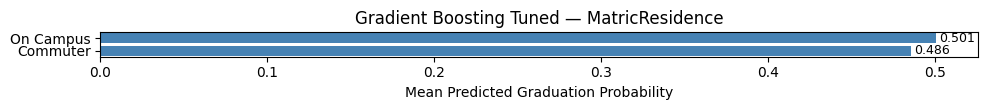

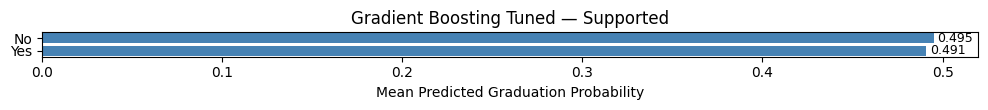

In [32]:
#  Category plots
plot_categorical_graphs(cat_summary, gaps, model_name)



Generating clean PDP plots for: Gradient Boosting Tuned



<Figure size 800x600 with 0 Axes>

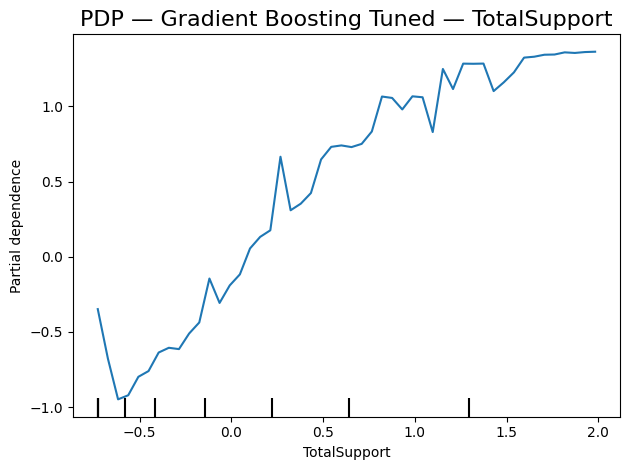

<Figure size 800x600 with 0 Axes>

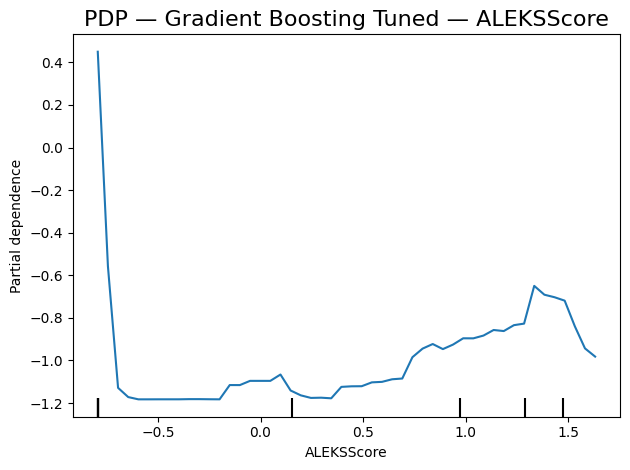

<Figure size 800x600 with 0 Axes>

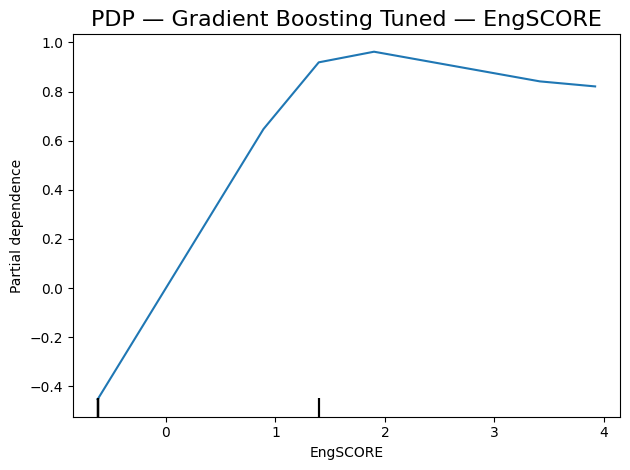

<Figure size 800x600 with 0 Axes>

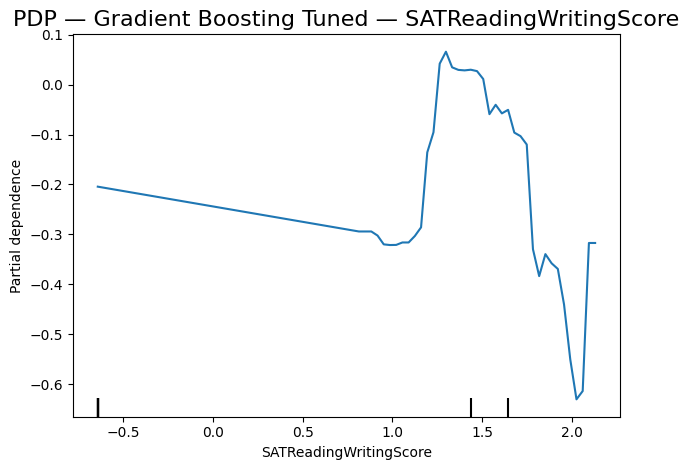

<Figure size 800x600 with 0 Axes>

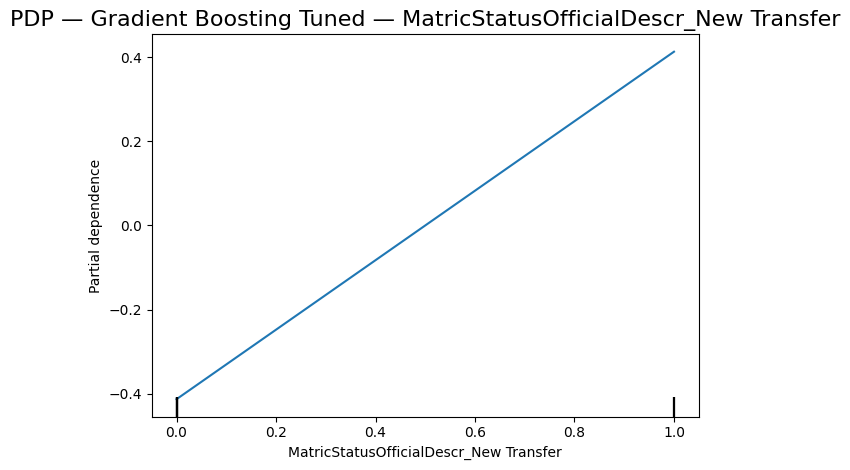

<Figure size 800x600 with 0 Axes>

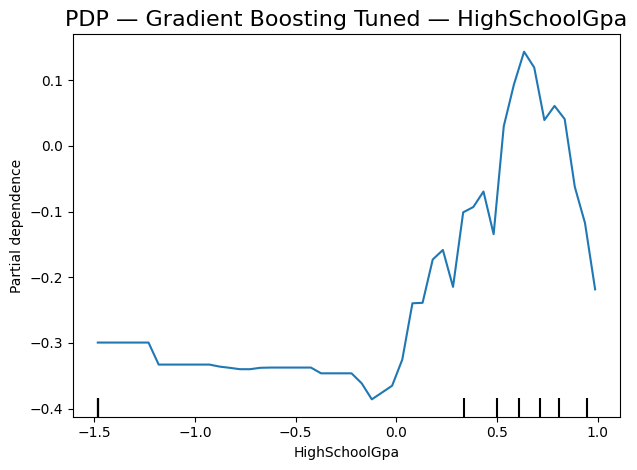

<Figure size 800x600 with 0 Axes>

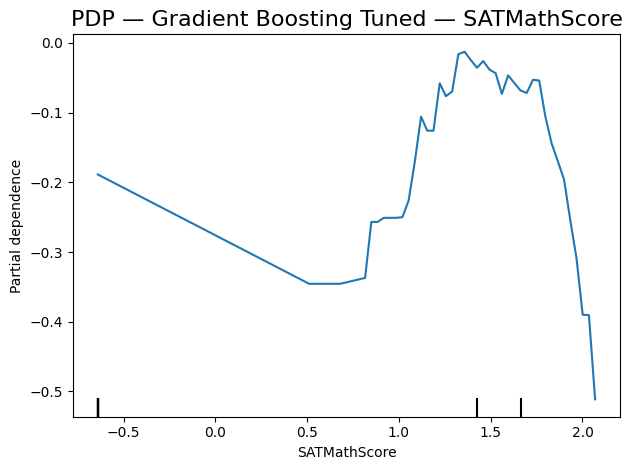

<Figure size 800x600 with 0 Axes>

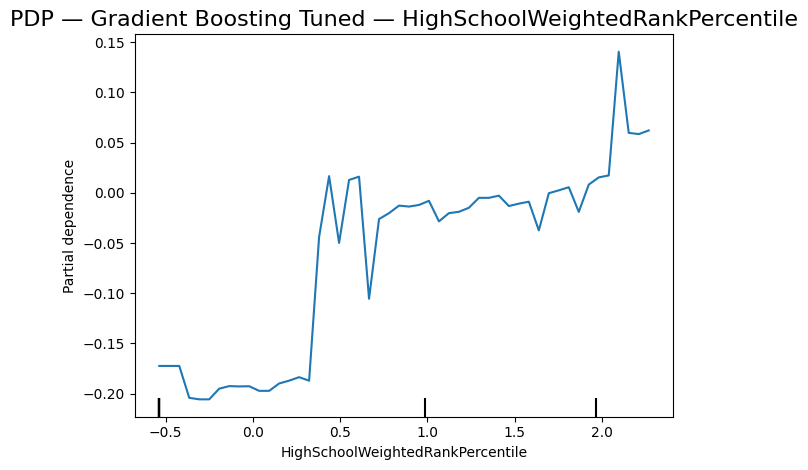

<Figure size 800x600 with 0 Axes>

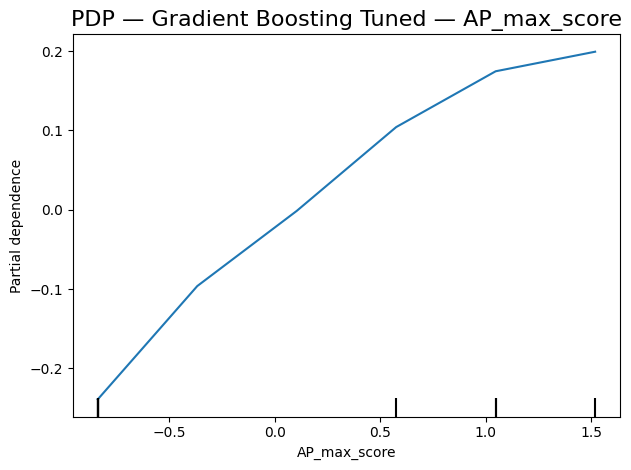

<Figure size 800x600 with 0 Axes>

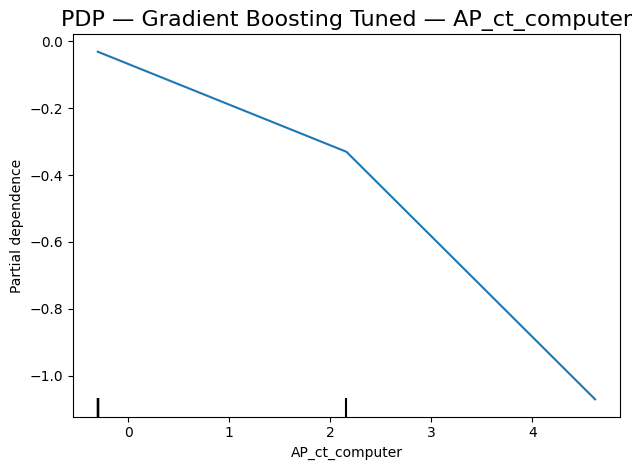

In [33]:
# PDP plots
plot_pdp(model, top_features, Xv, feature_names, model_name)

In [35]:
print("\n POLICY SIMULATION: Gradient Boosting Tuned")
policy_gb_noyear = run_policy_simulation_top20(gb_tuned_noyear, X, X_val)



 POLICY SIMULATION: Gradient Boosting Tuned

Baseline predicted probability: 0.493
 POLICY SIMULATION RESULTS (TOP 20 FEATURES) 
                         Feature        Type                                       Change  NewProb  Lift(pts)
       MatricStatusOfficialDescr Categorical                           Force=New Transfer   0.5822      8.966
            MatricIPEDSEthnicity Categorical                          Force=International   0.5387      4.616
            MatricIPEDSEthnicity Categorical                          Force=Not Specified   0.5371      4.461
            MatricIPEDSEthnicity Categorical                                  Force=Asian   0.5188      2.625
                   HighSchoolGpa     Numeric                                         +20%   0.5123      1.982
               MatricGenderIPEDS Categorical                                 Force=Female   0.5115      1.900
                   HighSchoolGpa     Numeric                                         +10%   0.5090  